In [1]:
## Dependencies

# Classic
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import Counter
import random

# Pytorch 
import torch
from torch import nn
from torch.optim import Adam
from torch.autograd import Variable
from torchvision import transforms, datasets
from IPython import display

seed = 42

## Creating the Dataset

In [28]:
## Loading the MNIST dataset

path = './data/torch_data/VGAN/MNIST/dataset'
compose = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((.5, .5, .5), (.5, .5, .5))])

train_dataset = datasets.MNIST(root = path, train = True, transform = compose, download = False)
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = 60000, shuffle = True)
test_dataset = datasets.MNIST(root = path, train = False, transform = compose, download = False)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,batch_size = 10000, shuffle = True)

In [34]:
np.random.seed(seed)

## Store the images into the repective train and test variables

data_list = [train_loader, test_loader]

## Loop through the datasets (train/test)
for data in data_list:

    for image, labels in data:
        
        if image.shape[0] == 60000:
            temp_idx = np.random.choice(image.shape[0], 50000, replace=False)
            train_x = image[temp_idx].detach().numpy()
            train_y = labels[temp_idx].detach().numpy()
        else:
            temp_idx = np.random.choice(image.shape[0], 7500, replace=False)
            test_x = image[temp_idx].detach().numpy()
            test_y = labels[temp_idx].detach().numpy()
            

In [35]:
np.random.seed(seed)

## Extract 30000 images for mnist and 20000 for autoencoders

random_idx = np.random.permutation(50000)
# Parsing train data amongst mnist and autoencoders
mnist_train_x = train_x[random_idx[:30000]]
mnist_train_y = train_y[random_idx[:30000]]
ae_train_x = train_x[random_idx[30000:]]
ae_train_y = train_y[random_idx[30000:]]


## Extract 5000 images for mnist and 2500 for autoencoders

random_idx = np.random.permutation(7500)
# Parsing test data amongst mnist and autoencoders
mnist_test_x = test_x[random_idx[:5000]]
mnist_test_y = test_y[random_idx[:5000]]
ae_test_x = test_x[random_idx[5000:]]
ae_test_y = test_y[random_idx[5000:]]

In [36]:
## Save train and test sets for autoencoders
np.save("data/ae_train_x", ae_train_x)
np.save("data/ae_test_x", ae_test_x)

## Load numpy tensors
# np.load("data/X_train.npy")

In [37]:
## Loading numpy tensors from autoencoders
ae_train_x_new = np.load('data/ae_train_x_new.npy')
#ae_train_x_new = (ae_train_x_new - 0.5)/0.5
ae_test_x_new = np.load('data/ae_test_x_new.npy')
#ae_test_x_new = (ae_test_x_new - 0.5)/0.5

In [38]:
np.random.seed(seed)

## Reading and storing images from DC_GAN
train_x_gan = np.empty((10000,1,28,28))
train_y_gan = np.empty((10000,))
test_x_gan = np.empty((2500,1,28,28))
test_y_gan = np.empty((2500,))

for digit in range(10):
    
    temp_image = np.load("data/{}.npy".format(digit))
    train_y_gan[digit*1000:(digit+1)*1000] = digit
    test_y_gan[digit*250:(digit+1)*250] = digit
    
    for image in range(1250):
        
        img = cv2.resize(temp_image[image][0], (28, 28)) 
        img = img.reshape((1,28,28))
        if image < 1000:
            train_x_gan[digit*1000 + image] = img
        else:
            test_x_gan[digit*250 + (image-1000)] = img

            
## Randomize the set

# Train
idx = np.random.permutation(10000)
train_x_gan = train_x_gan[idx]
train_y_gan = train_y_gan[idx]
# Test
idx = np.random.permutation(2500)
test_x_gan = test_x_gan[idx]
test_y_gan = test_y_gan[idx]

In [39]:
## Data normalization between (0,1)

# Normalize function
def normalize(matrix):
    
    return (matrix - matrix.min())/(matrix.max() - matrix.min())

# MNIST train and test
mnist_train_x = normalize(mnist_train_x)
mnist_test_x = normalize(mnist_test_x)

# Autoencoder train
for n,i in enumerate(ae_train_x_new):
    ae_train_x_new[n] = normalize(i)
# Autoencoder test
for n,i in enumerate(ae_test_x_new):
    ae_test_x_new[n] = normalize(i)
    
# DC-GANs train
for n,i in enumerate(train_x_gan):
    train_x_gan[n] = normalize(i)
# DC-GANs test
for n,i in enumerate(test_x_gan):
    test_x_gan[n] = normalize(i)   

In [43]:
np.random.seed(seed)

## Creating the dataset:
train_X = np.concatenate((mnist_train_x, ae_train_x_new, train_x_gan), axis = 0)
train_Y = np.concatenate((mnist_train_y, ae_train_y, train_y_gan), axis = 0)
test_X = np.concatenate((mnist_test_x, ae_test_x_new, test_x_gan), axis = 0)
test_Y = np.concatenate((mnist_test_y, ae_test_y, test_y_gan), axis = 0)

## Final shuffle
train_idx = np.random.permutation(60000)
train_X = train_X[train_idx]
train_Y = train_Y[train_idx]

test_idx = np.random.permutation(10000)
test_X = test_X[test_idx]
test_Y = test_Y[test_idx]


## Saving the datasets
np.save('data/train_X', train_X)
np.save('data/train_Y', train_Y)
np.save('data/test_X', test_X)
np.save('data/test_Y', test_Y)

0.0

In [ ]:
train_X = np.load()
train_Y = np.concatenate((mnist_train_y, ae_train_y, train_y_gan), axis = 0)
test_X = np.concatenate((mnist_test_x, ae_test_x_new, test_x_gan), axis = 0)
test_Y = np.concatenate((mnist_test_y, ae_test_y, test_y_gan), axis = 0)


## Loading the Dataset

In [504]:
"""
The train dataset was creating by:
    - Using 30000 randomly picked instances from the MNIST dataset
    - Using 20000 instances generated using an autoencoder 
    - Using 10000 instances generated using DCGAN
    
The test dataset was created by:
    - Using 5000 randomly picked instances from the MNIST dataset
    - Using 2500 instances generated using an autoencoder 
    - Using 2500 instances generated using DCGAN

train_X - a 60000*1*28*28 tensor : features 
train_y - a 60000*1 tensor : labels

test_X - a 10000*1*28*28 tensor : features 
test_Y - a 10000*1 tensor : labels
"""
print("The shape of the train data set is {}".format(train_X.shape))
print("The shape of the test data set is {}".format(test_X.shape))

The shape of the train data set is (60000, 1, 28, 28)
The shape of the test data set is (10000, 1, 28, 28)


In [402]:
## Loading the datasets
# np.load(path)
# np.load("data/X_train.npy") <-- example

The image id is 57267
The generated image is a 3.0


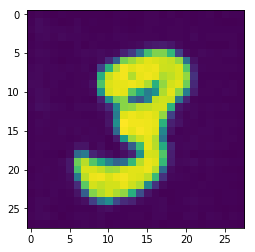

In [100]:
## Playing around with Train dataset 
idx = np.random.choice(60000,1)[0]
plt.imshow(train_X[idx][0])
print("The image id is {}".format(idx))
print("The generated image is a {}".format(train_Y[idx]))
plt.show()

The image id is 7079
The generated image is a 9.0


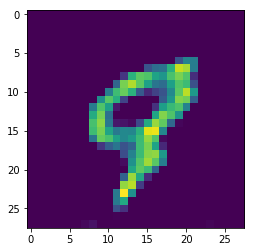

In [102]:
## Playing around with Test dataset 
idx = np.random.choice(10000,1)[0]
plt.imshow(test_X[idx][0])
print("The image id is {}".format(idx))
print("The generated image is a {}".format(test_Y[idx]))
plt.show()

In [17]:
import numpy as np

In [29]:
STORAGE = np.load('../Numerical Method/data/STORAGE_3.npy')
relevant_idx = list()
for i in range(len(STORAGE)):
    relevant_idx.append(STORAGE[i,-1])

In [30]:
len(relevant_idx)

5369